# 트랜스포머로 만드는 대화형 챗봇👄

## 학습 목표
- 트랜스포머의 인코더 디코더 구조 이해하기
- 내부 단어 토크나이저 사용하기
- 셀프 어텐션 이해하기
- 한국어에도 적용해보기

## 루브릭
|평가문항|상세기준|
|:---|:---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

## 1. 데이터 수집하기

[챗봇 데이터](https://github.com/songys/Chatbot_data)

이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연"에서 자주 나오는 이야기들을 참고하여 제작되었습니다. 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성하였습니다.

- 챗봇 트레이닝용 문답 페어 11,876개
- 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filepath = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/'
data = pd.read_csv(filepath +'ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 2. 데이터 전처리 하기

- 정해진 개수인 11,823개의 질문과 답변의 쌍을 추출합니다.
- 문장에서 단어와 구두점 사이에 공백을 추가합니다.
- 한글 및알파벳, ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거합니다.

In [3]:
data.shape

(11823, 3)

In [4]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(data)):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(data['Q'].values[i]))
      outputs.append(preprocess_sentence(data['A'].values[i]))
    return inputs, outputs

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 후의 10번째 질문 샘플: {}'.format(questions[9]))
print('전처리 후의 10번째 답변 샘플: {}'.format(answers[9]))

전처리 후의 10번째 질문 샘플: sns 시간낭비인데 자꾸 보게됨
전처리 후의 10번째 답변 샘플: 시간을 정하고 해보세요 .


## 3. 병렬 데이터 전처리 하기

1. TensorFlow Datasets __SubwordTextEncoder__ 를 토크나이저로 사용합니다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 __정수로 인코딩__합니다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 __START_TOKEN 및 END_TOKEN__ 을 추가합니다.
3. 최대 길이 __MAX_LENGTH__ 인 40을 넘는 문장들은 필터링합니다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 __패딩__ 처리 합니다.

### 3.1 단어장(Vocabulary) 만들기

- 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


### 3.2 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
- tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의 합니다.
- tokenizer.encode()로 각 단어를 정수로 변환할 수 있으며
- tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 610, 2483, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7484, 7, 6249, 97, 1]


- 질문과 답변 셋에 대해서 전부 정수 인코딩을 수행합니다.
- 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 합니다.

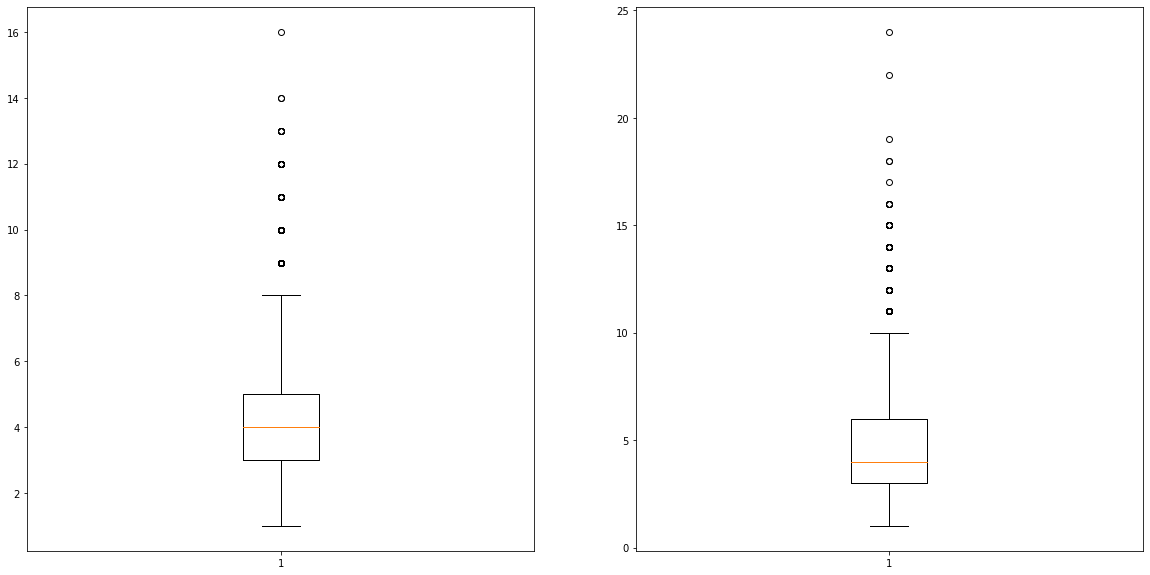

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9391017508246637
질문의 중앙값 길이 : 4.0
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716146494121627
답변의 중앙값 길이 : 4.0


In [14]:
# 질문과 답변의 길이
questions_length = [len(w.split()) for w in questions]
answers_length = [len(w.split()) for w in answers]

plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
plt.boxplot(questions_length)
ax = plt.subplot(1,2,2)
plt.boxplot(answers_length)
plt.show()

print('질문의 최소 길이 : {}'.format(np.min(questions_length)))
print('질문의 최대 길이 : {}'.format(np.max(questions_length)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_length)))
print('질문의 중앙값 길이 : {}'.format(np.median(questions_length)))
print('답변의 최소 길이 : {}'.format(np.min(answers_length)))
print('답변의 최대 길이 : {}'.format(np.max(answers_length)))
print('답변의 평균 길이 : {}'.format(np.mean(answers_length)))
print('답변의 중앙값 길이 : {}'.format(np.median(answers_length)))

In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 24
print(MAX_LENGTH)

24


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 11815
필터링 후의 답변 샘플 개수: 11815


### 3.3 교사 강요(Teacher Forcing) 사용하기
- 교사 강요(teacher forcing)란, 훈련시 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용합니다.
- 훈련 과정에서도 이전 시점의 출력을 다음 시점의 입력으로 사용하면서 훈련 시킬 수도 있지만 이는 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되므로 교사 강요를 사용하여 RNN을 좀 더 빠르고 효과적으로 훈련시킬 수 있습니다.
- 파이프라인을 구성합니다. 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성하기

### 4.1 함수 생성

#### Positional Encoding
- 트랜스포머는 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용하는 포지셔널 인코딩(Positional Encoding) 작업이 추가됩니다.
- 단어의 어순을 모델에 전달하기 위해, 임베딩 벡터에 위치정보를 가진 벡터(Positional Encoding)값을 더해 모델의 입력으로 만들어 주게됩니다.

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)) # d_model 나눠주는 값은 0, 0, 2, 2, 4, 4, 6, 6 이런 식으로 반복되어야하기 때문에 2i가 아닌 2 * (i // 2)를 사용 
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### 트랜스포머에서 사용된 어텐션
트랜스포머는 세 가지의 어텐션을 사용합니다.
![attentions](https://wikidocs.net/images/page/31379/attention.PNG)
1. 인코더에서 이루어지는 __Encoder Self-Attention__<br>
    : 인코더의 입력으로 들어간 문장 내 단어들간의 유사도를 구한다. 
2. 디코더에서 이루어지는 __Masked Decoder Self-Attention__<br>
    : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
3. 디코더에서 이루어지는 __Encoder-Decoder Attention__<br>
    : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.
    
- 트랜스포커의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value)는 기본적으로 '단어(정보를 함축한) 벡터'입니다.

#### Scaled dot-product Attention

트랜스포머에서 어텐션 값을 구하는 방법으로는 아래와 같은 수식을 사용합니다.

$$Attention(Q, K, V)=softmax(\frac{{QK}^T}{\sqrt{d_k}})V$$

- Q,K,V는 쿼리(Query), 키(Key), 값(Value)를 나타냅니다.
- Q, K, V는 단어 벡터를 행으로 하는 문장 행렬
- 벡터의 내적(dot product) 은 벡터의 유사도
- 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling), 이 과정때문에 이름에 Scaled가 붙은 것입니다.
- 유사도를 Normalize해주기 위해서 Softmax 함수를 사용(0~1사이의 값,즉 확률)

In [20]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

#### Multi-Head Attention

- 트랜스포머에서 num_heads라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터입니다.
- num_heads의 값이 8일 때, 병렬로 수행되는 어텐션은 서로 다른 어텐션 결과를 얻을 수 있습니다.
- 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있습니다. 
- 이와 같이 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 부릅니다
![multi-head attention](https://wikidocs.net/images/page/31379/transformer18_final.PNG)

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

#### Padding Masking
- 패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법입니다.
- 그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있습니다. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크합니다.

In [22]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

#### Look-ahead masking, 다음 단어 가리기
- 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 
- 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 
- 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법입니다.
- 이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 합니다.
- 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다. 그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출합니다.

In [23]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

#### Encoder
하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다.
1. __셀프 어텐션__ (셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다.)
2. __피드 포워드 신경망__

In [24]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [25]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### Decoder
하나의 디코더 층은 크게 총 3개의 서브 층(sublayer)으로 나누어집니다.
1. __셀프어텐션__
2. __인코더-디코더 어텐션__
3. __피드 포워드 신경망__

In [26]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [27]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### Transformer

In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 4.2 모델 정의

In [65]:
### 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수 , 논문 값:6
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원, 논문 값:512
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    16781824    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 4.3 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [66]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 4.4 커스텀 된 학습률(Learning rate)
- 커스텀 학습률 스케줄링(Custom Learning rate Scheduling): 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법

$$lrate=d^{-0.5}_{model}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})$$

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

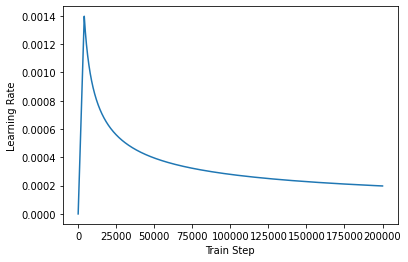

In [68]:
# 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4.5 모델 컴파일(Compile)

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [69]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4.6 모델 훈련

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = filepath + 'transformer' + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/aiffel/aiffel/transformer_chatbot/data/transformer -- Folder already exists 



In [71]:
EPOCHS = 30
history  = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
185/185 [==============================] - 83s 352ms/step - loss: 2.4487 - accuracy: 0.0302


Epoch 2/30
185/185 [==============================] - 64s 348ms/step - loss: 1.8576 - accuracy: 0.0841


Epoch 3/30
185/185 [==============================] - 65s 352ms/step - loss: 1.6624 - accuracy: 0.0858


Epoch 4/30
185/185 [==============================] - 65s 351ms/step - loss: 1.5883 - accuracy: 0.0899


Epoch 5/30
185/185 [==============================] - 66s 355ms/step - loss: 1.5183 - accuracy: 0.0939


Epoch 6/30
185/185 [==============================] - 66s 357ms/step - loss: 1.4492 - accuracy: 0.0968


Epoch 7/30
185/185 [==============================] - 66s 357ms/step - loss: 1.3907 - accuracy: 0.1005


Epoch 8/30
185/185 [==============================] - 65s 352ms/step - loss: 1.3062 - accuracy: 0.1053


Epoch 9/30
185/185 [==============================] - 66s 356ms/step - loss: 1.2273 - accuracy: 0.1125


Epoch 10/30
185/185 [==============================] - 66s 359ms/step - loss: 1.1368 - accuracy: 0.1200


Epoch 11/30
185/185 [==============================] - 66s 359ms/step - loss: 1.0370 - accuracy: 0.1306


Epoch 12/30
185/185 [==============================] - 67s 361ms/step - loss: 0.9304 - accuracy: 0.1435


Epoch 13/30
185/185 [==============================] - 66s 357ms/step - loss: 0.8460 - accuracy: 0.1559


Epoch 14/30
185/185 [==============================] - 67s 361ms/step - loss: 0.7578 - accuracy: 0.1664


Epoch 15/30
185/185 [==============================] - 67s 361ms/step - loss: 0.6840 - accuracy: 0.1759


Epoch 16/30
185/185 [==============================] - 67s 360ms/step - loss: 0.6205 - accuracy: 0.1867


Epoch 17/30
185/185 [==============================] - 68s 367ms/step - loss: 0.5748 - accuracy: 0.1927


Epoch 18/30
185/185 [==============================] - 68s 368ms/step - loss: 0.5385 - accuracy: 0.2002


Epoch 19/30
185/185 [==============================] - 68s 367ms/step - loss: 0.5132 - accuracy: 0.2003


Epoch 20/30
185/185 [==============================] - 68s 369ms/step - loss: 0.4932 - accuracy: 0.2053


Epoch 21/30
185/185 [==============================] - 68s 366ms/step - loss: 0.4850 - accuracy: 0.2047


Epoch 22/30
185/185 [==============================] - 68s 365ms/step - loss: 0.4781 - accuracy: 0.2083


Epoch 23/30
185/185 [==============================] - 67s 364ms/step - loss: 0.4626 - accuracy: 0.2103


Epoch 24/30
185/185 [==============================] - 69s 370ms/step - loss: 0.4452 - accuracy: 0.2122


Epoch 25/30
185/185 [==============================] - 67s 364ms/step - loss: 0.4306 - accuracy: 0.2163


Epoch 26/30
185/185 [==============================] - 69s 371ms/step - loss: 0.4150 - accuracy: 0.2201


Epoch 27/30
185/185 [==============================] - 69s 374ms/step - loss: 0.4042 - accuracy: 0.2214


Epoch 28/30
185/185 [==============================] - 68s 370ms/step - loss: 0.3954 - accuracy: 0.2237


Epoch 29/30
185/185 [==============================] - 67s 363ms/step - loss: 0.3869 - accuracy: 0.2242


Epoch 30/30
185/185 [==============================] - 69s 372ms/step - loss: 0.3771 - accuracy: 0.2246


## 5. 챗봇 평가하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [72]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [73]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [74]:
sentence_generation('안녕하세요.')

입력 : 안녕하세요.
출력 : 축하드려요 .


'축하드려요 .'

In [75]:
sentence_generation('벌써 금요일이네요.')

입력 : 벌써 금요일이네요.
출력 : 저도 해보고 싶은 알바예요 .


'저도 해보고 싶은 알바예요 .'

In [76]:
sentence_generation('요즘 컨디션이 안좋네요.')

입력 : 요즘 컨디션이 안좋네요.
출력 : 많이 만나보세요 .


'많이 만나보세요 .'

In [77]:
sentence_generation('심심하다')

입력 : 심심하다
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [78]:
sentence_generation('너는 뭘 좋아해?')

입력 : 너는 뭘 좋아해?
출력 : 저는 고민이 없어요 .


'저는 고민이 없어요 .'

In [79]:
sentence_generation('고마워!')

입력 : 고마워!
출력 : 회사에는 동료가 있을 뿐이에요 .


'회사에는 동료가 있을 뿐이에요 .'

In [80]:
sentence_generation('날씨가 어때?')

입력 : 날씨가 어때?
출력 : 제가 채워줄게요 .


'제가 채워줄게요 .'

In [81]:
sentence_generation('피곤하다')

입력 : 피곤하다
출력 : 저도 해보고 싶은 알바예요 .


'저도 해보고 싶은 알바예요 .'

***

## 프로젝트 정리

- 이번 프로젝트는 트랜스포머 구조를 배울 수 있었다.😁
- 하이퍼파라미터는 논문에 구현된 수로 입력하여 학습하였지만, Accuracy가 매우 낮았고 질문에 대한 답변이 엉뚱한 편이었다.
- 하이퍼파라미터를 조정하면서 결과물을 확인했지만, Accuracy는 매우 낮은 편이다. 결과를 분석하기 위해서는 구조에 대한 이해가 더 필요하다.
- 챗봇의 답변은 그럴 듯한 답변도 있지만 아직 만족스러운 수준은 아니다.


- 결과물 비교
|      | Hyper Parameters | Results|
|:------:|:------------------|:--------|
| try1 | NUM_LAYERS = 6<br> D_MODEL = 512<br> NUM_HEADS = 8<br> UNITS = 2048<br> DROPOUT = 0.1<br> | Q : 안녕하세요. A : 보험처리 하세요 .<br>  Q : 벌써 금요일이네요. A : 감기 조심하세요 .<br> Q : 요즘 컨디션이 안좋네요. A : 충분히 그럴 수 있어요 .<br>  Q : 심심하다 A : 친구들과 함께면 어디든 좋아요 .<br>  Q : 너는 뭘 좋아해? A : 직접 물어보세요 .<br>  Q : 고마워! A : 오늘 회사 가기 싫은가봐요 .<br> |  
|try2|NUM_LAYERS = 2 	<br> D_MODEL = 512   <br> NUM_HEADS = 8   <br> UNITS = 2048    <br> DROPOUT = 0.1   <br>|Q : 안녕하세요. A : 안녕하세요 .<br> Q : 벌써 금요일이네요. A : 시간이 필요한 때인 것 같아요 . <br> Q : 요즘 컨디션이 안좋네요. A : 그건 좋아하는 게 아니에요 .<br> Q : 심심하다 A : 저랑 놀아요 .<br> Q : 너는 뭘 좋아해? A : 사랑이 아닌게 되지는 않아요 .<br> Q : 고마워! A : 감사합니다 .<br> Q : 날씨가 어때? A : 집밖에 나가기가 힘들것 같아요 .<br>  Q : 피곤하다 A : 너무 자책하지 마세요 .<br>|
|try3|NUM_LAYERS = 6<br> D_MODEL = 512 <br> NUM_HEADS = 8 <br> UNITS = 1024  <br> DROPOUT = 0.1 <br>|Q : 안녕하세요. A : 축하드려요 .<br> Q : 벌써 금요일이네요. A : 저도 해보고 싶은 알바예요 .<br> Q : 요즘 컨디션이 안좋네요. A : 많이 만나보세요 .<br> Q : 심심하다 A : 맛있는 거 드세요 .<br> Q : 너는 뭘 좋아해? A : 저는 고민이 없어요 .<br> Q : 고마워! A : 회사에는 동료가 있을 뿐이에요 .<br> Q : 날씨가 어때? A : 제가 채워줄게요 .<br> Q : 피곤하다 A : 저도 해보고 싶은 알바예요 .<br> |